In [94]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import save_model
import glob
import os 
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from keras.optimizers import SGD
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import files
%matplotlib inline

In [95]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [96]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/assets-cancer'
basal_dir = os.path.join(base_dir, 'basal')
melanoma_dir = os.path.join(base_dir, 'melanoma')
vascular_dir = os.path.join(base_dir, 'vascular')

In [97]:
os.listdir('/content/drive/MyDrive/Colab Notebooks/assets-cancer')

['basal', 'melanoma', 'vascular']

In [98]:
total_image = len(list(glob.iglob("/content/drive/MyDrive/Colab Notebooks/assets-cancer/*/*.*", recursive=True)))
print("Total Data Image          : ",total_image)

total_basal = len(os.listdir(basal_dir))
total_melanoma = len(os.listdir(melanoma_dir))
total_vascular = len(os.listdir(vascular_dir))

# Mencetak jumlah data kanker kulit basal, melanoma, vascular
print("Total Data Basal          : ",total_basal)
print("Total Data Melanoma       : ",total_melanoma)
print("Total Data Vascular       : ",total_vascular)

Total Data Image          :  390
Total Data Basal          :  130
Total Data Melanoma       :  130
Total Data Vascular       :  130


**Implementasi augmentasi citra dengan Image Data Generator**

In [99]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    horizontal_flip=True,
    fill_mode = 'nearest',
    validation_split = 0.2
)
 
val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    horizontal_flip=True,
    fill_mode = 'nearest',
    validation_split = 0.2                                    
)

**Melakukan pemisahan dataset menjadi train dan validation**

In [100]:
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size = (128,128),
    batch_size = 16,
    shuffle = True,
    color_mode = "rgb",
    class_mode = "categorical",
    subset = "training"
    
)

validation_generator = val_datagen.flow_from_directory(
    base_dir,
    target_size = (128,128),
    batch_size = 16,
    shuffle = True,
    color_mode = "rgb",
    class_mode = "categorical",
    subset = "validation"
    
)

Found 312 images belonging to 3 classes.
Found 78 images belonging to 3 classes.


In [101]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), strides = (1,1),  activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), padding = 'valid'), 
    tf.keras.layers.Conv2D(64, (3,3), strides = (1,1), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), padding = 'valid'),
    tf.keras.layers.Conv2D(128, (3,3), strides = (1,1), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), padding = 'valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(0.001))
])


In [102]:
Adam(learning_rate=0.001, name='Adam')
model.compile(optimizer = 'Adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [103]:
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs', histogram_freq=0, write_graph=True, write_images=False,
    update_freq='epoch', embeddings_freq=0,
    embeddings_metadata=None
)

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 14, 14, 128)     

In [104]:
accuracy = 0.97

class func_callback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('accuracy') >= accuracy):
			print("Akurasi Telah Mencapai %2.2f%% , Proses Training Dihentikan." %(accuracy*100))
			self.model.stop_training = True
      
callback = func_callback()

In [105]:
batch_size = 16

history = model.fit(
          train_generator,
          steps_per_epoch=312//batch_size,  
          epochs=25,  
          validation_data=validation_generator, 
          validation_steps=78//batch_size,  
          verbose=2,
          callbacks=[lr_schedule, callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/25
19/19 - 10s - loss: 1.0670 - accuracy: 0.4628 - val_loss: 0.7943 - val_accuracy: 0.6250 - lr: 0.0010 - 10s/epoch - 505ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/25
19/19 - 9s - loss: 0.7642 - accuracy: 0.6588 - val_loss: 0.7492 - val_accuracy: 0.6406 - lr: 0.0010 - 9s/epoch - 460ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/25
19/19 - 9s - loss: 0.5661 - accuracy: 0.7669 - val_loss: 0.7305 - val_accuracy: 0.8125 - lr: 0.0010 - 9s/epoch - 458ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/25
19/19 - 9s - loss: 0.5107 - accuracy: 0.7872 - val_loss: 0.6588 - val_accuracy: 0.8125 - lr: 0.0010 - 9s/epoch - 461ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/25
19/19 - 9s - loss: 0.4467 - accuracy: 0.8345 - 

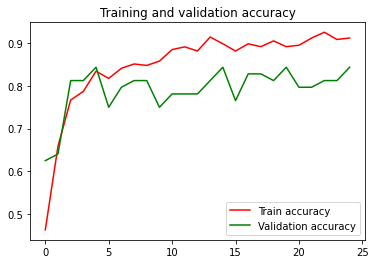

<Figure size 432x288 with 0 Axes>

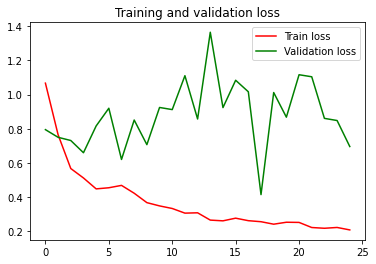

<Figure size 432x288 with 0 Axes>

In [106]:
# Mengambil Nilai Accuracy 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
# Mengambil Nilai Loss 
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Plot Accruracy
plt.plot(epochs, acc, 'r', label='Train accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

# Plot Loss
plt.plot(epochs, loss, 'r', label='Train loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()